In [2]:
using LinearAlgebra
using Plots
using StaticArrays
using TrajectoryOptimization
import TrajectoryOptimization:dynamics

In [9]:
struct Qubit <: AbstractModel
      n::Int
      m::Int
end

function dynamics(model::Qubit,x,ü)
      #Pauli spin matrices
      i2 = SMatrix{2,2}([0 -1; 1 0]) #2x2 unit imaginary matrix
      # Sx = SMatrix{4,4}([zeros(2,2) I; I zeros(2,2)])
      # Sy = SMatrix{4,4}([zeros(2,2) -i2; i2 zeros(2,2)])
      # Sz = SMatrix{4,4}([I zeros(2,2); zeros(2,2) -I])
      iSx = SMatrix{4,4}([zeros(2,2) i2; i2 zeros(2,2)])
      # iSy = SMatrix{4,4}([zeros(2,2) I; -I zeros(2,2)])
      iSz = SMatrix{4,4}([i2 zeros(2,2); zeros(2,2) -i2])

      u̇ = x[9]
      u = x[10]
      ẋ = [(-iSx - u.*iSz)*x[1:4]; (-iSx - u.*iSz)*x[5:8]; ü; u̇; u]
end

dynamics (generic function with 9 methods)

In [10]:
n = 2*4 + 3 # state dimension
m = 1     # input dimension
model = Qubit(n,m)

Qubit(11, 1)

In [11]:
dt = 0.01 #time step
N = 101 #number of knot points
tf = dt*(N-1)

#initial state(s)  
x0 = @SVector [1.0, 0, 0, 0,       # |0> 
               0, 0, 1.0, 0,     # |1>
               0, 0, 0]          # controls
#final state(s) for Y pi/2 gate
xf = @SVector [1/sqrt(2), 0, 1/sqrt(2), 0,
              -1/sqrt(2), 0, 1/sqrt(2), 0,
               0, 0, 0] #desired final state

U0 = [@SVector randn(m) for k = 1:N-1] #random initial guess for control inputs
X0 = [@SVector fill(NaN,n) for k = 1:N];
Z = Traj(X0,U0,dt*ones(N));

In [12]:
#Set up quadratic objective function
Q = Diagonal(@SVector [1e-3, 1e-3, 1e-3, 1e-3, 
                       1e-3, 1e-3, 1e-3, 1e-3,
                       1, 1, 1e-3])
R = 1.0*Diagonal(@SVector ones(m))
Qf = 1.0*Diagonal(@SVector ones(n))
obj = LQRObjective(Q,R,Qf,xf,N);

In [13]:
#Set up constriants
goal = GoalConstraint(xf)
con_goal = ConstraintVals(goal, N:N)
conSet = ConstraintSet(n,m,[con_goal], N);

In [14]:
#Set up and solve traj. opt. problem
prob = Problem{RK3}(model, obj, conSet, x0, xf, Z, N, tf)
opts = ALTROSolverOptions{Float64}(verbose=true,projected_newton=false)
solver = ALTROSolver(prob, opts)
solve!(solver)

In [17]:
X̃ = states(solver)
X1 = zeros(4,N)
X2 = zeros(4,N)
U = zeros(N)
U̇ = zeros(N)
for k = 1:N
      X1[:,k] = X̃[k][1:4]
      X2[:,k] = X̃[k][5:8]
      U[k] = X̃[k][9]
      U̇[k] = X̃[k][10]
end

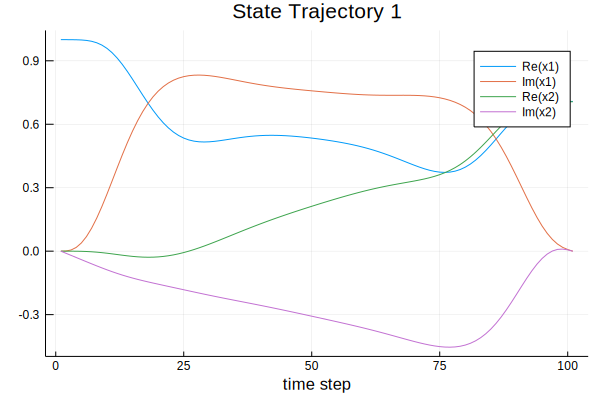

In [18]:
plot(X1',xlabel="time step",title="State Trajectory 1",label=["Re(x1)" "Im(x1)" "Re(x2)" "Im(x2)"])

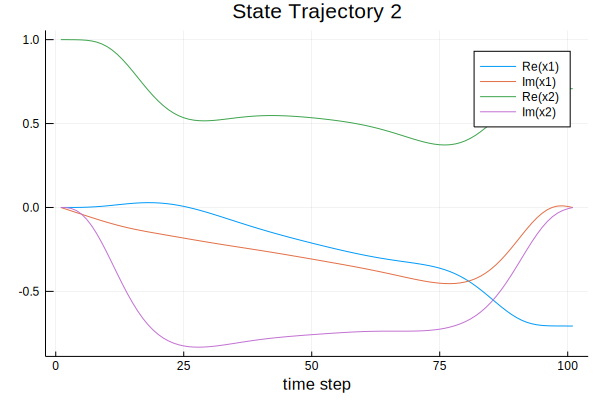

In [19]:
plot(X2',xlabel="time step",title="State Trajectory 2",label=["Re(x1)" "Im(x1)" "Re(x2)" "Im(x2)"])

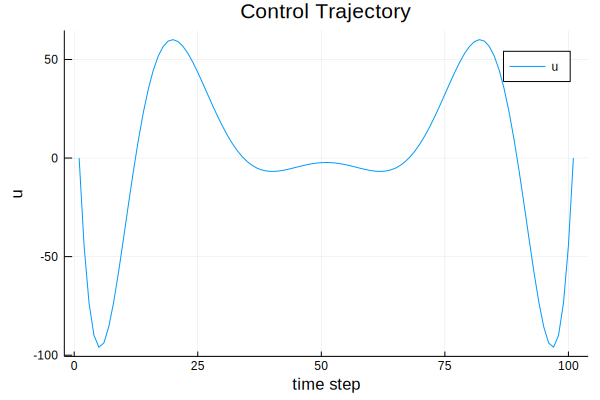

In [20]:
plot(U,xlabel="time step",ylabel="u",title="Control Trajectory",label="u")

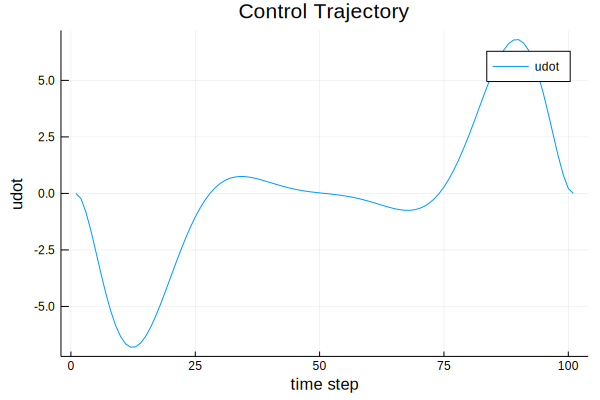

In [21]:
plot(U̇,xlabel="time step",ylabel="udot",title="Control Trajectory",label="udot")